In [10]:
import numpy as np
import fixed_income_derivatives_E2025 as fid
import matplotlib.pyplot as plt
from scipy.optimize import minimize  # , Bounds, NonlinearConstraint
from scipy.special import ndtr

def fit_sabr_obj(param,sigma_market,K,T,R):
    sigma_0, beta, upsilon, rho = param
    N = len(sigma_market)
    y = 0
    for n in range(0,N):
        sigma_sabr = fid.sigma_sabr(K[n], T, R, sigma_0, beta, upsilon, rho)
        y += (sigma_market[n]-sigma_sabr)**2
    return y

alpha = 0.25
T_max = 10
r0, a, b, sigma_vasicek = 0.025, 0.5, 0.025, 0.02
K_swaption_offset = [-300,-250,-200,-150,-100,-50,0,50,100,150,200,250,300]
price_swaption = np.array([0.1098731, 0.09271305, 0.07596615, 0.05986245, 0.04478005, 0.0313187, 0.02029072, 0.01236822, 0.00743971, 0.00463353, 0.00304943, 0.00211939, 0.00154348])
idx_exer, idx_mat = 20, 40



In [11]:
# Zero coupon bond prices
M = int(round(T_max/alpha))
T = np.array([i*alpha for i in range(0,M+1)])
R = fid.spot_rate_vasicek(r0,a,b,sigma_vasicek,T)
p = fid.zcb_prices_from_spot_rates(T,R)
L = fid.forward_rates_from_zcb_prices(T,p,horizon = 1)
N_swaption = len(K_swaption_offset)
S_swap = 0
for i in range(idx_exer+1,idx_mat + 1):
    S_swap += alpha*p[i]
R_swap = (p[idx_exer] - p[idx_mat])/S_swap
print(f"S_swap: {S_swap}, R_swap: {R_swap}")
iv, K = np.zeros([N_swaption]), np.zeros([N_swaption])
for i in range(0,N_swaption):
    K[i] = R_swap + K_swaption_offset[i]/10000
    iv[i] = fid.black_swaption_iv(price_swaption[i],T[idx_exer],K[i],S_swap,R_swap,type_option = "call", iv0 = 0.2, max_iter = 1000, prec = 1.0e-12)
print(f"Implied volatilities deduced from market prices:")
print(iv)



S_swap: 3.607499968449148, R_swap: 0.048755775325442056
Implied volatilities deduced from market prices:
[0.27388055 0.23620995 0.20584277 0.18059703 0.15949259 0.14237526
 0.12977518 0.12241585 0.12011712 0.12147192 0.12488039 0.12925964
 0.13401714]


In [13]:
# Fitting the SABR model
param_0 = 0.03, 0.5, 0.4,-0.3
result = minimize(fit_sabr_obj,param_0,method = 'nelder-mead',args = (iv,K,T[idx_exer],R_swap),options={'xatol': 1e-8,'disp': True})
sigma_0, beta, upsilon, rho = result.x
print(f"Parameters from fit. sigma_0: {sigma_0}, beta: {beta}, upsilon: {upsilon}, rho: {rho}")
iv_fit = np.zeros([N_swaption])
for i in range(0,N_swaption):
    iv_fit[i] = fid.sigma_sabr(K[i], T[idx_exer], R_swap, sigma_0, beta, upsilon, rho)
print(f"Implied volatilities deduced from fitted prices:")
print(iv_fit)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 279
         Function evaluations: 476
Parameters from fit. sigma_0: 0.02550991057685728, beta: 0.4780982124201416, upsilon: 0.4084808868780906, rho: -0.3090469714421906
Implied volatilities deduced from fitted prices:
[0.27382137 0.2362686  0.20589747 0.18060897 0.15946238 0.14232634
 0.12974211 0.12242185 0.12015357 0.12151193 0.12490165 0.12924949
 0.13396993]


mu: -3.0293524191733803, sigma: 0.12977518123655774


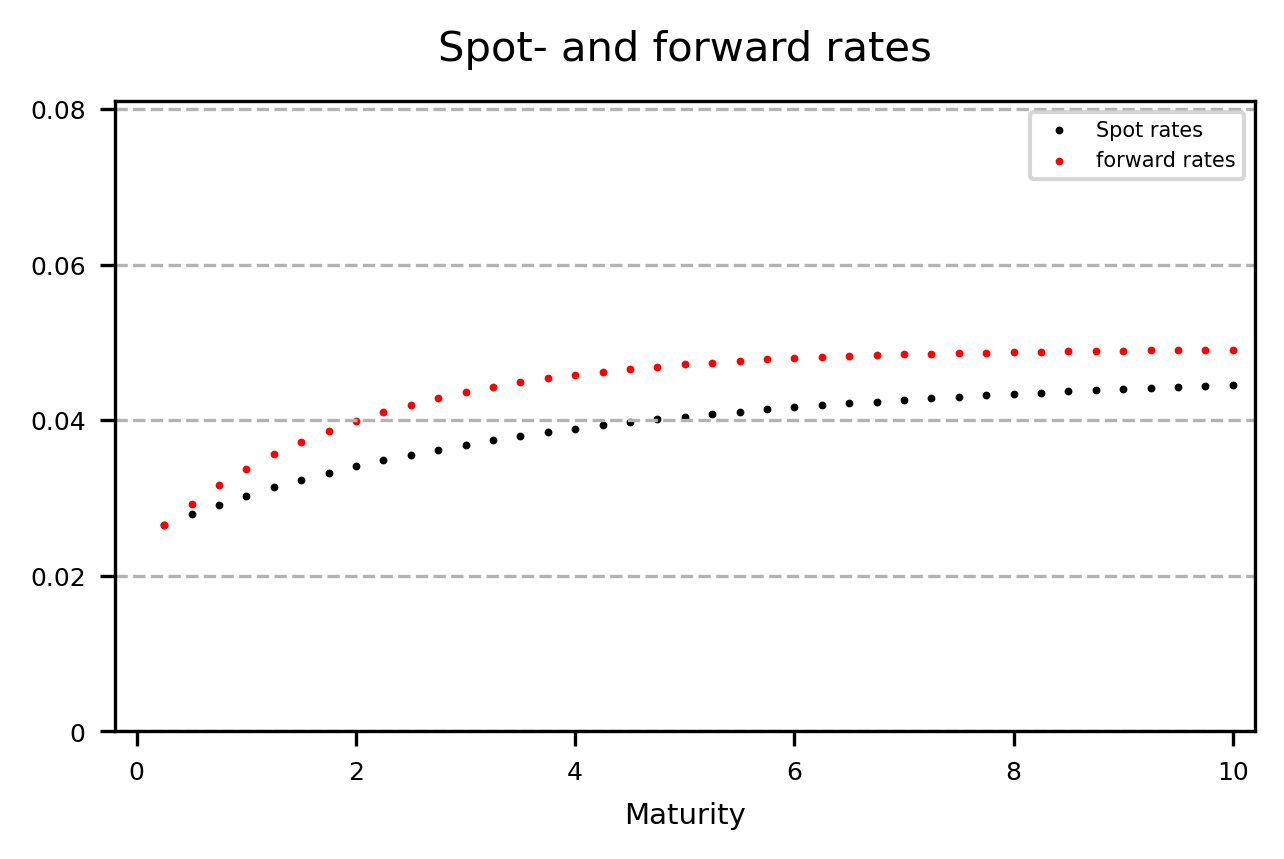

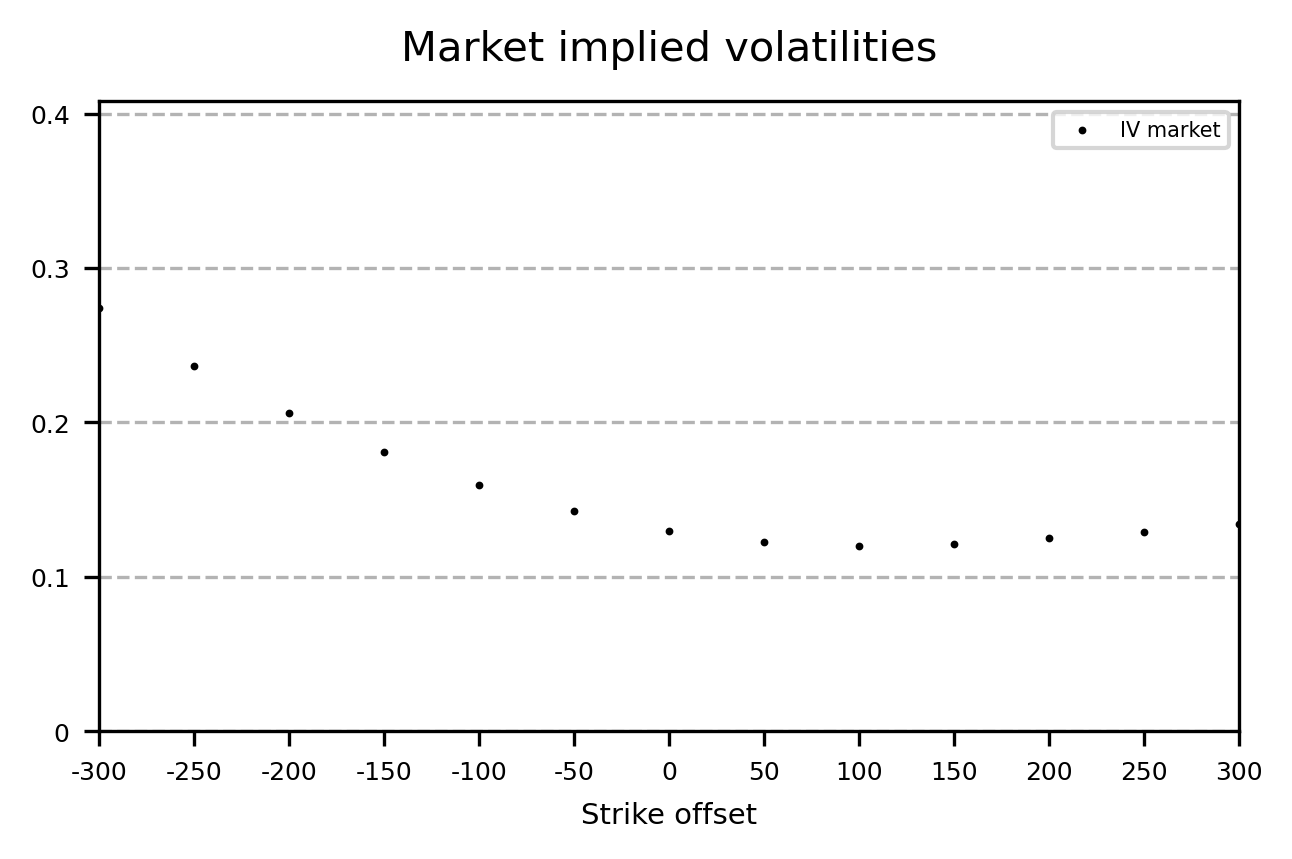

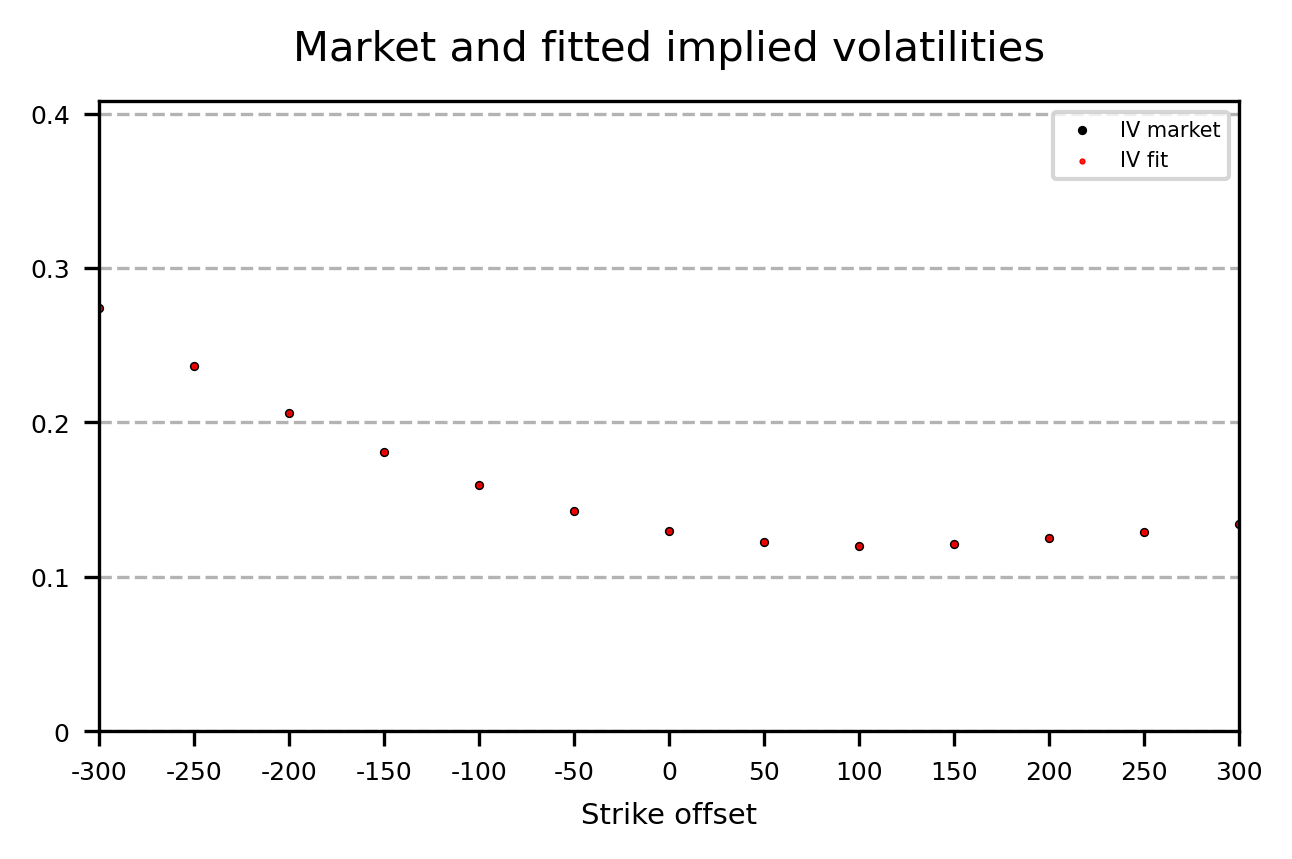

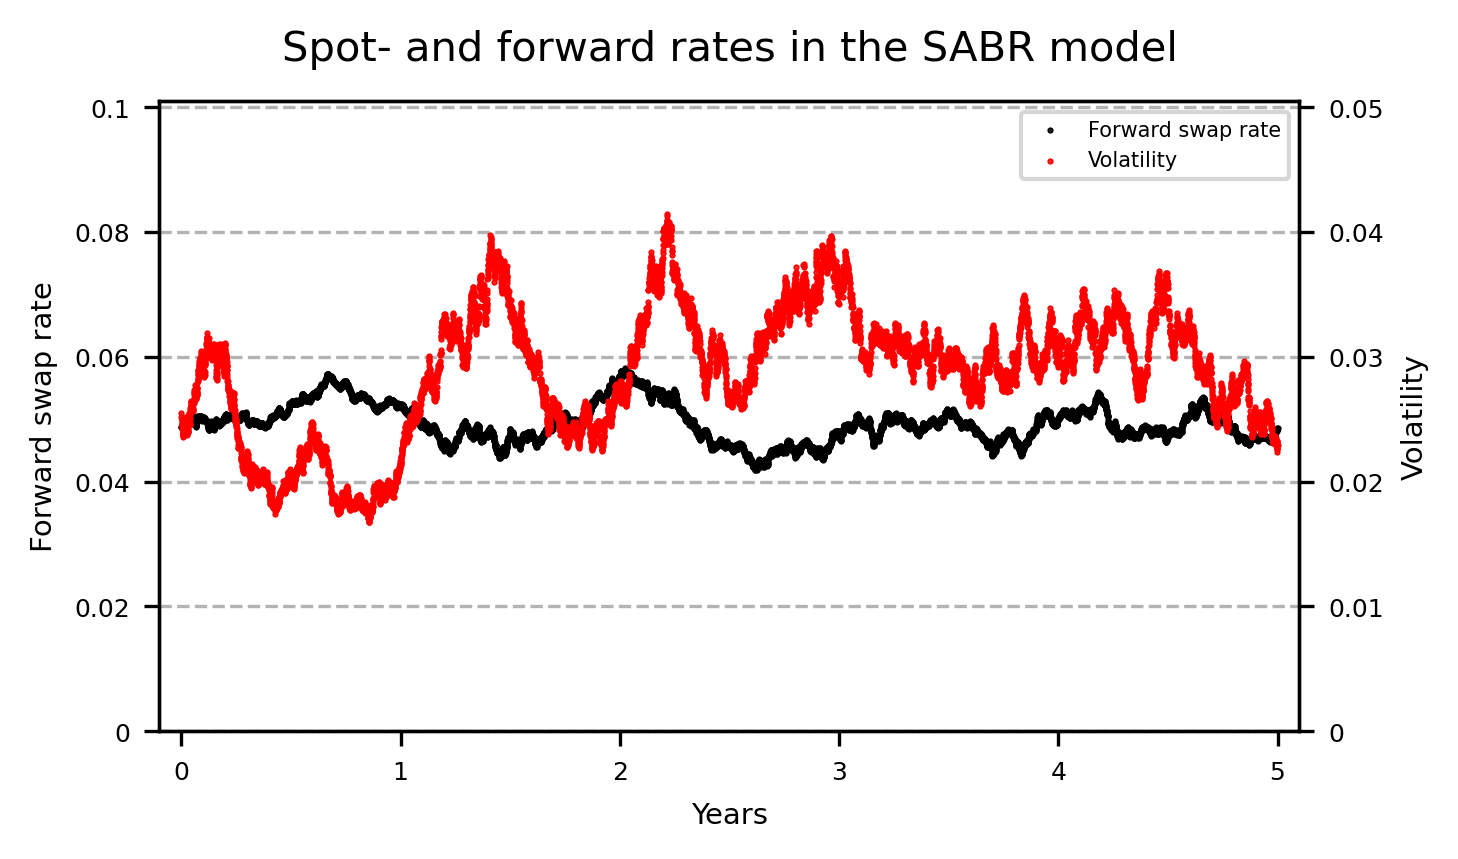

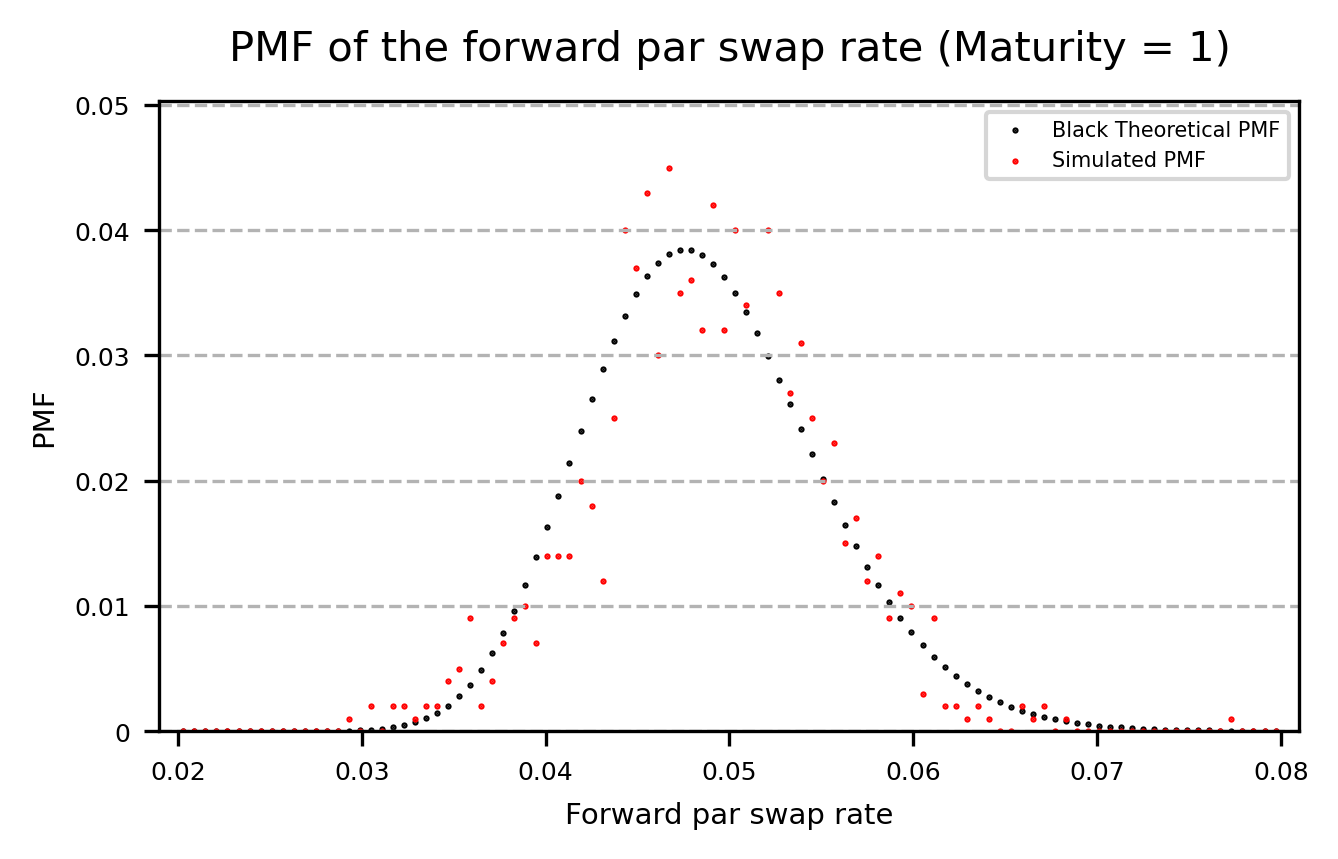

In [14]:
# Simulating the SABR model
np.random.seed(5)  # Plot that looks realistic
# np.random.seed(3)  # Volatility blows up and forward rate goes negative
# np.random.seed(6)  # Volatility freexes at 0 and forwrad rate freezes
# np.random.seed(27)
T_simul, M_simul = 5, 10000
F_simul, sigma_simul = fid.sabr_simul(R_swap,sigma_0, beta, upsilon, rho,M_simul,T_simul)
t_simul = np.array([i*T_simul/M_simul for i in range(0,M_simul+1)])


# Plotting the density function of the forward rate
T_simul_dens, M_simul_dens, N_simul_dens = 1, 1000, 1000
F_simul_dens, sigma_simul_dens = np.zeros([N_simul_dens]), np.zeros([N_simul_dens])
F_simul_temp, sigma_simul_temp = np.zeros([M_simul_dens]), np.zeros([M_simul_dens])
for n in range(0,N_simul_dens):
    F_simul_temp, sigma_simul_temp = fid.sabr_simul(R_swap,sigma_0,beta,upsilon,rho,M_simul_dens,T_simul_dens)
    F_simul_dens[n], sigma_simul_dens[n] = F_simul_temp[-1], sigma_simul_temp[-1]

def vector_to_bins(v,mini,maxi,N):
    v = np.sort(v,kind="heapsort")
    mesh = (maxi-mini)/N
    lb, ub = np.array([mini+i*mesh for i in range(0,N)]), np.array([mini+i*mesh for i in range(1,N+1)])
    y = np.zeros([N])
    i, j, count = 0, 0, 0
    while i < N:
        if v[j] < lb[i]:
            # print(f"A, i: {i}, lb: {lb[i]}, ub: {ub[i]}, j: {j}, v: {v[j]},count: {count}, y: {y}")
            j += 1
        if lb[i] <= v[j] <= ub[i]:
            count += 1
            # print(f"B, i: {i}, lb: {lb[i]}, ub: {ub[i]}, j: {j}, v: {v[j]},count: {count}, y: {y}")
            j += 1
        elif ub[i] < v[j]:
            y[i] = count
            count = 0
            # print(f"C, i: {i}, lb: {lb[i]}, ub: {ub[i]}, j: {j}, v: {v[j]},count: {count}, y: {y}")
            i += 1
        if j > len(v) - 0.5:
            y[i] = count
            i = N
        # print(f"    after", i,lb[i],ub[i],j,v[j],count,y)
    return y, lb, ub

F_bins_N, F_min, F_max = 100, 0.02, 0.08
counts, lb, ub = vector_to_bins(F_simul_dens,F_min,F_max,F_bins_N)
simul_pmf = counts/sum(counts)
bins = 0.5*(lb + ub)
sigma = iv[int((N_swaption-1)/2)]*np.sqrt(T_simul_dens)
mu = np.log(R_swap) - 0.5*sigma**2
black_pmf = np.zeros([F_bins_N])
for i in range(0,F_bins_N):
    black_pmf[i] = ndtr(((np.log(ub[i])-mu))/sigma) - ndtr(((np.log(lb[i])-mu))/sigma)
print(f"mu: {mu}, sigma: {sigma}")

# PLot of spot and forward rates
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Spot- and forward rates", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 7)
ax.set_yticks([0,0.02,0.04,0.06,0.08])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08],fontsize = 6)
ax.set_ylim([0,0.081])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T[1:], R[1:], s = 3, color = 'black', marker = ".",label="Spot rates")
p2 = ax.scatter(T[1:], L[1:], s = 3, color = 'red', marker = ".",label="forward rates")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
plt.show()

# Plot of market implied volatilities
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Market implied volatilities", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = K_swaption_offset
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.02,xticks[-1]+0.02])
plt.xlabel(f"Strike offset",fontsize = 7)
ax.set_yticks([0,0.1,0.2,0.3,0.4])
ax.set_yticklabels([0,0.1,0.2,0.3,0.4],fontsize = 6)
ax.set_ylim([0,0.408])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(K_swaption_offset, iv, s = 3, color = 'black', marker = ".",label="IV market")
plots = [p1]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
plt.show()

# Market and fitted implied volatilities
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Market and fitted implied volatilities", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = K_swaption_offset
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.02,xticks[-1]+0.02])
plt.xlabel(f"Strike offset",fontsize = 7)
ax.set_yticks([0,0.1,0.2,0.3,0.4])
ax.set_yticklabels([0,0.1,0.2,0.3,0.4],fontsize = 6)
ax.set_ylim([0,0.408])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(K_swaption_offset, iv, s = 6, color = 'black', marker = ".",label="IV market")
p2 = ax.scatter(K_swaption_offset, iv_fit, s = 1, color = 'red', marker = ".",label="IV fit")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
plt.show()

# PLot of simulated values of the SABR model
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Spot- and forward rates in the SABR model", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.1,xticks[-1]+0.1])
plt.xlabel(f"Years",fontsize = 7)
ax.set_yticks([0,0.02,0.04,0.06,0.08,0.1])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08,0.1],fontsize = 6)
ax.set_ylim([0,0.101])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Forward swap rate",fontsize = 7)
p1 = ax.scatter(t_simul, F_simul, s = 1, color = 'black', marker = ".",label="Forward swap rate")
ax2 = ax.twinx()
ax2.set_yticks([0,0.01,0.02,0.03,0.04,0.05])
ax2.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05],fontsize = 6)
ax2.set_ylim([0,0.0505])
ax2.set_ylabel(f"Volatility",fontsize = 7)
p2 = ax2.scatter(t_simul, sigma_simul, s = 1, color = 'red', marker = ".",label="Volatility")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
plt.show()

# Plot of simulated and theoretical density of the forward par swap rate
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"PMF of the forward par swap rate (Maturity = {T_simul_dens})", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0.02,0.03,0.04,0.05,0.06,0.07,0.08]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.001,xticks[-1]+0.001])
ax.set_xlabel(f"Forward par swap rate",fontsize = 7)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05],fontsize = 6)
ax.set_ylim([0,0.0503])
ax.set_ylabel(f"PMF",fontsize = 7)
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(bins, black_pmf, s = 1, color = 'black', marker = ".",label="Black Theoretical PMF")
p2 = ax.scatter(bins, simul_pmf, s = 1, color = 'red', marker = ".",label="Simulated PMF")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
plt.show()
